In [8]:
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.ToTensor(), #将图像转化为tensor，并将像素值缩到[0,1]之间
    transforms.Normalize((0.1307, ), (0.3081, )) #对数据进行标准化 这两个数字式统计计算后得到的 MNIST 数据集的均值和标准差 有助于加快收敛速度
])

# 加载MNIST训练集和测试集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
class ResMLP(nn.Module):
    def __init__(self):
        super(ResMLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)  # 确保输入输出维度相同以便残差连接
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 64)  # 确保输入输出维度相同以便残差连接
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平输入
        
        # 第一层
        out = self.relu(self.fc1(x))
        
        # 第二层 + 残差连接
        residual = out
        out = self.relu(self.fc2(out))
        out = out + residual 
        
        # 第三层
        out = self.relu(self.fc3(out))
        
        # 第四层 + 残差连接
        residual = out
        out = self.relu(self.fc4(out))
        out = out + residual# 添加残差
        
        # 输出层
        out = self.fc5(out)
        
        return out
# 指定训练模型的环境
device = torch.device('cpu') # 我们没有cuda 所以指定为CPU
model = ResMLP().to(device)
# 输出网络结构
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(model, train_loader, optimizer, criterion, device):
    # 将模型设置为训练模式
    model.train()  
    train_loss = 0
    correct = 0
    total = 0
    # 遍历训练集
    for inputs, labels in train_loader:
        # 将输入数据和标签移动到指定设备
        inputs, labels = inputs.to(device), labels.to(device)
        # 梯度清零
        optimizer.zero_grad()  
        # 前向传播计算输出
        outputs = model(inputs)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播更新参数
        loss.backward()
        optimizer.step()
        # 统计总损失、预测正确的样本数和总样本数
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    acc = correct / total
    return train_loss, acc
def test(model, test_loader, criterion, device):
    # 将模型设置为评估模式
    model.eval()
    
    test_loss = 0  
    correct = 0    
    total = 0      
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # 计算损失
            
            test_loss += loss.item()  # 累加测试集上的总损失
            _, predicted = outputs.max(1)  # 获取预测结果中概率最大的类别
            total += labels.size(0)  # 累加样本数
            correct += predicted.eq(labels).sum().item()  # 统计预测正确的样本数
    
    acc = correct / total  
    return test_loss, acc

ResMLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


Epoch 1/10, Train Loss: 216.3221, Train Acc: 0.9297, Test Loss: 17.8141, Test Acc: 0.9656
Epoch 2/10, Train Loss: 89.7139, Train Acc: 0.9706, Test Loss: 13.1412, Test Acc: 0.9733
Epoch 3/10, Train Loss: 62.5659, Train Acc: 0.9787, Test Loss: 12.9681, Test Acc: 0.9760
Epoch 4/10, Train Loss: 51.1582, Train Acc: 0.9826, Test Loss: 12.4638, Test Acc: 0.9760
Epoch 5/10, Train Loss: 39.0540, Train Acc: 0.9863, Test Loss: 12.6107, Test Acc: 0.9754
Epoch 6/10, Train Loss: 33.8802, Train Acc: 0.9883, Test Loss: 13.1791, Test Acc: 0.9769
Epoch 7/10, Train Loss: 27.8957, Train Acc: 0.9906, Test Loss: 14.3610, Test Acc: 0.9769
Epoch 8/10, Train Loss: 26.5841, Train Acc: 0.9906, Test Loss: 13.1263, Test Acc: 0.9802
Epoch 9/10, Train Loss: 23.4648, Train Acc: 0.9916, Test Loss: 13.4188, Test Acc: 0.9796
Epoch 10/10, Train Loss: 21.4034, Train Acc: 0.9924, Test Loss: 12.4278, Test Acc: 0.9811


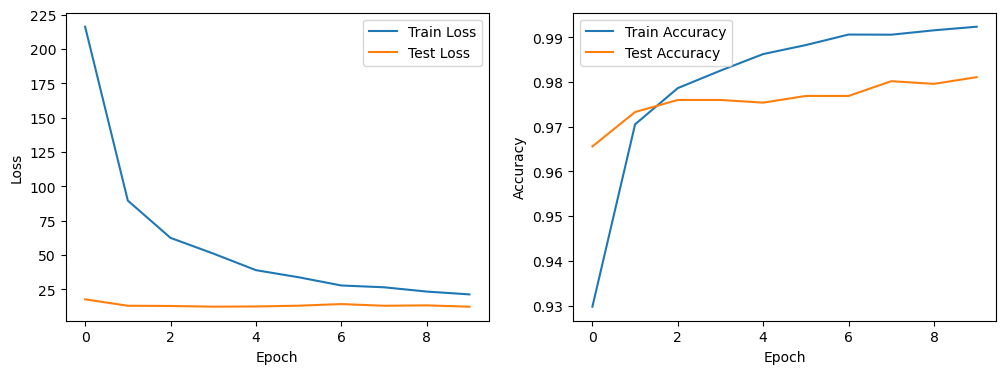

In [10]:
num_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# 绘制损失和准确度曲线


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # 绘制损失和准确度曲线
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return train_losses, test_losses, train_accs, test_accs

In [15]:
class DeepMLP(nn.Module):
    def __init__(self):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

DeepMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 1/10, Train Loss: 591.8549, Train Acc: 0.8268, Test Loss: 24.1409, Test Acc: 0.9548
Epoch 2/10, Train Loss: 302.8744, Train Acc: 0.9168, Test Loss: 18.0425, Test Acc: 0.9671
Epoch 3/10, Train Loss: 246.1358, Train Acc: 0.9330, Test Loss: 15.9895, Test Acc: 

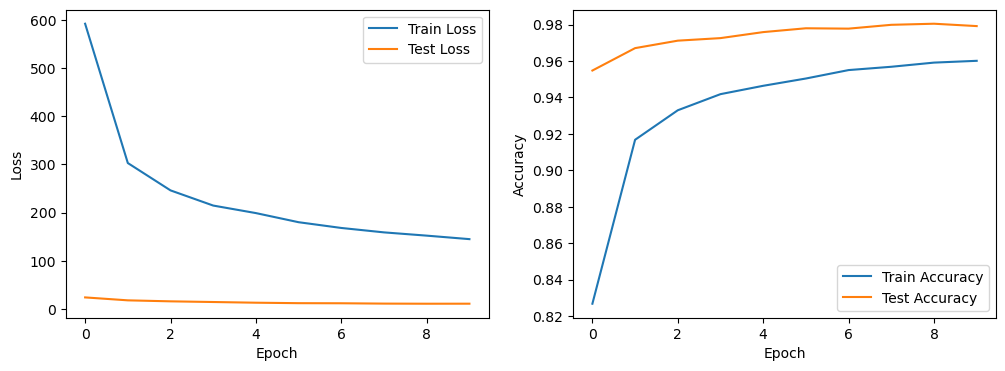

([591.8549293875694,
  302.8744265884161,
  246.13583808392286,
  214.65684005618095,
  199.0383184850216,
  180.11144820787013,
  168.1899903351441,
  159.02531975880265,
  152.26369924284518,
  145.01872514002025],
 [24.140915140043944,
  18.042480112984776,
  15.989514424174558,
  14.582727090339176,
  13.145201018167427,
  12.175668620198849,
  11.986924842378357,
  11.283001953961502,
  11.040740478601947,
  11.10115476163628],
 [0.8267666666666666,
  0.9167833333333333,
  0.9329833333333334,
  0.9418333333333333,
  0.9464166666666667,
  0.9504166666666667,
  0.95505,
  0.9568666666666666,
  0.95915,
  0.9601333333333333],
 [0.9548,
  0.9671,
  0.9712,
  0.9726,
  0.9759,
  0.978,
  0.9778,
  0.9799,
  0.9805,
  0.9792])

In [16]:
model = DeepMLP().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10)

In [17]:
class wide_MLP(nn.Module):
    def __init__(self):
        super(wide_MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512) #前一个是输入 后一个是输出
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU() # 这里选取的是ReLU函数作为激活函数
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # 将输入展平
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

wide_MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)
Epoch 1/10, Train Loss: 208.1651, Train Acc: 0.9322, Test Loss: 17.5645, Test Acc: 0.9645
Epoch 2/10, Train Loss: 81.2691, Train Acc: 0.9731, Test Loss: 14.8479, Test Acc: 0.9698
Epoch 3/10, Train Loss: 55.1731, Train Acc: 0.9812, Test Loss: 10.3777, Test Acc: 0.9801
Epoch 4/10, Train Loss: 41.6617, Train Acc: 0.9857, Test Loss: 12.3175, Test Acc: 0.9768
Epoch 5/10, Train Loss: 36.2846, Train Acc: 0.9876, Test Loss: 10.2069, Test Acc: 0.9802
Epoch 6/10, Train Loss: 26.6799, Train Acc: 0.9903, Test Loss: 12.6861, Test Acc: 0.9786
Epoch 7/10, Train Loss: 23.5218, Train Acc: 0.9919, Test Loss: 12.9256, Test Acc: 0.9772
Epoch 8/10, Train Loss: 19.4462, Train Acc: 0.9929, Test Loss: 13.5735, Test Acc: 0.9778
Epoch 9/10, Train Loss: 20.4269, Train Acc: 0.9926, Test Loss: 11.0868, Tes

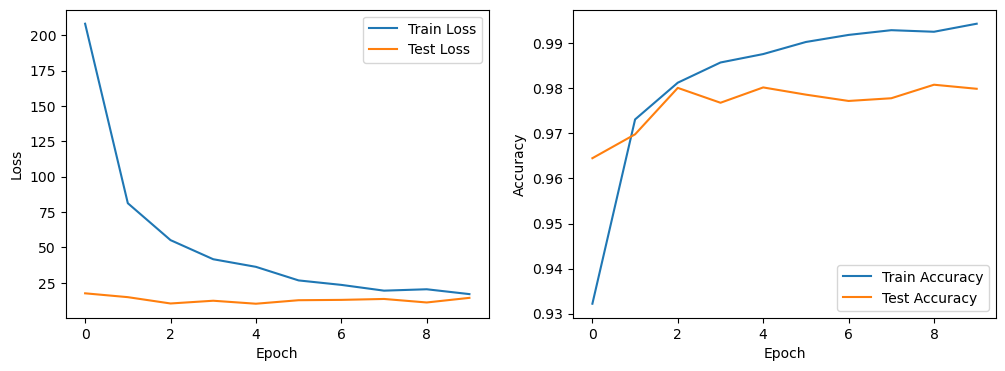

([208.1650573639199,
  81.26911984733306,
  55.173058353946544,
  41.66171827039216,
  36.28462555425358,
  26.67993578009191,
  23.52181939370348,
  19.44616706103261,
  20.426939223536465,
  17.00100739111076],
 [17.56452899693977,
  14.847938159131445,
  10.377705783335841,
  12.31745700668398,
  10.206854211108293,
  12.686079177468855,
  12.925632696555112,
  13.573543527918446,
  11.086820552734025,
  14.358824944175922],
 [0.9322166666666667,
  0.9731,
  0.98125,
  0.9857333333333334,
  0.9876,
  0.9902833333333333,
  0.99185,
  0.9929,
  0.99255,
  0.9943333333333333],
 [0.9645,
  0.9698,
  0.9801,
  0.9768,
  0.9802,
  0.9786,
  0.9772,
  0.9778,
  0.9808,
  0.9799])

In [18]:
model = wide_MLP().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10)

In [36]:
def find_lr(model, train_loader, criterion, init_lr=1e-5, max_lr=1, num_iter=100):
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    lr_values = []
    losses = []

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= num_iter:
            break
        lr = init_lr * (max_lr / init_lr) ** (i / num_iter)
        optimizer.param_groups[0]['lr'] = lr

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        lr_values.append(lr)
        losses.append(loss.item())

    plt.plot(lr_values, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs Loss')
    plt.show()


In [37]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 256) #前一个是输入 后一个是输出
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU() # 这里选取的是ReLU函数作为激活函数
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # 将输入展平
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

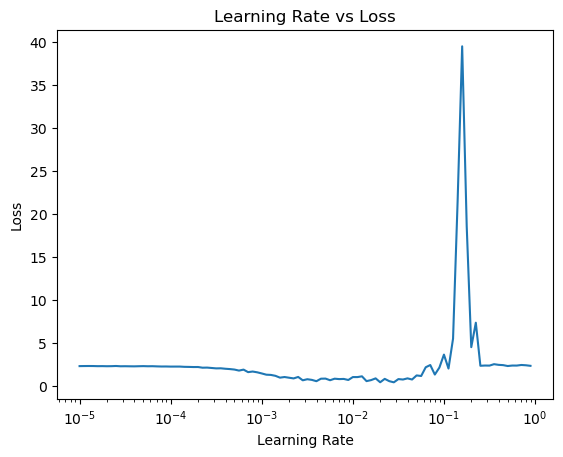

In [38]:
model = MLP()
criterion = nn.CrossEntropyLoss()
find_lr(model, train_loader, criterion)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)
Epoch 1/10, Train Loss: 211.2034, Train Acc: 0.9321, Test Loss: 16.3602, Test Acc: 0.9680
Epoch 2/10, Train Loss: 89.5434, Train Acc: 0.9706, Test Loss: 15.0220, Test Acc: 0.9711
Epoch 3/10, Train Loss: 64.6075, Train Acc: 0.9785, Test Loss: 14.0046, Test Acc: 0.9724
Epoch 4/10, Train Loss: 51.4842, Train Acc: 0.9825, Test Loss: 14.0182, Test Acc: 0.9755
Epoch 5/10, Train Loss: 42.2880, Train Acc: 0.9852, Test Loss: 12.7334, Test Acc: 0.9783
Epoch 6/10, Train Loss: 38.7728, Train Acc: 0.9861, Test Loss: 13.3376, Test Acc: 0.9770
Epoch 7/10, Train Loss: 28.3795, Train Acc: 0.9902, Test Loss: 13.9396, Test Acc: 0.9765
Epoch 8/10, Train Loss: 29.1312, Train Acc: 0.9897, Test Loss: 13.3005, Test Acc: 0.9780
Epoch 9/10, Train Loss: 23.5720, Train Acc: 0.9919, Test Loss: 20.2139, Test Acc

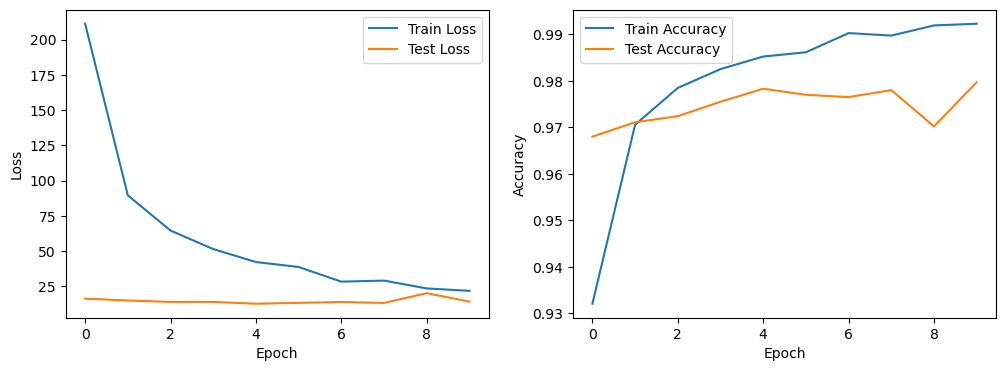

([211.203363860026,
  89.54336216882803,
  64.60749459872022,
  51.48416332772467,
  42.287982669542544,
  38.772781037550885,
  28.37946503784042,
  29.131205259429407,
  23.571969435746723,
  21.857810963949305],
 [16.360227751662023,
  15.02202345704427,
  14.004599962645443,
  14.018218004312075,
  12.733376951728133,
  13.337634105973848,
  13.939564935917588,
  13.300507458692664,
  20.213868352969257,
  14.251033910720565],
 [0.9321,
  0.9705666666666667,
  0.9784666666666667,
  0.9825166666666667,
  0.9852166666666666,
  0.9861333333333333,
  0.99025,
  0.9897166666666667,
  0.9919,
  0.9922666666666666],
 [0.968, 0.9711, 0.9724, 0.9755, 0.9783, 0.977, 0.9765, 0.978, 0.9702, 0.9797])

In [42]:
model = MLP().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.0015)
criterion = nn.CrossEntropyLoss()

train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10)